In [1]:
# ignore this
%load_ext music21.ipython21

# User's Guide, Chapter 16: TinyNotation

So far in this User's Guide, we've been loading music into `music21` either with one of the `corpus.parse` or `converter.parse` methods, which is great if you already have a piece of music in the corpus or in a file somewhere, or by building up a score note by note using the `stream.Stream()` and `note.Note()` objects.

But suppose that you want to get some music into `music21` that is too long to use the `note.Note()` build up, but too short to be worth firing up your notation editor to make a file? As you might imagine, this was a problem that the `music21` design team encountered often during the early development stages of the system, and we created our own solution with a format called "TinyNotation".

As its name implies, TinyNotation is designed to be a simple and lightweight notation syntax for getting simple music into `music21` (and from there, into the larger world).  It borrows from earlier simple notation solutions, especially Lilypond's syntax (but also ABC Notation and Humdrum/Kern).  I also tried to learn from their growth compared to more structured notation systems, such as MusicXML.  What I discovered is that the simpler a system is at inputting simple notes, the more complex that format is when dealing with really complex music. It's a major problem with simple solutions.

TinyNotation tries to avoid this limitation by, I'm serious here, making more complex notation impossible!  Parsing TinyNotation should always be easy to do, because it is intentionally extremely limited.  However, as we will demonstrate below, we designed TinyNotation so it would be easy to subclass into NotSoTinyNotation dialects that will, we hope, make _your_ particular notational needs possible (and pretty simple).  Let's begin with the basics, and we'll start with examples.

Here's a bunch of quarter notes in 4/4:

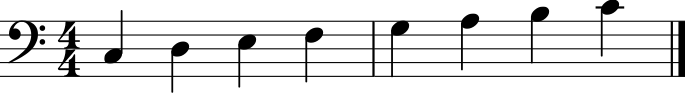

In [2]:
s = converter.parse('tinyNotation: 4/4 C4 D4 E4 F4 G4 A4 B4 c4')
s.show()

Notice that the last "c" is lowercase, while the rest of the notes are uppercase.  Case determines octave: "C" = the c in bass clef (C3) while "c" = middle C (C4).  Here are some other octaves:

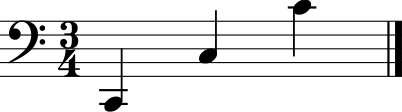

In [3]:
s = converter.parse("tinyNotation: 3/4 CC4 C4 c4")
s.show()

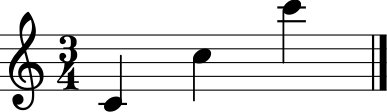

In [4]:
s = converter.parse("tinyNotation: 3/4 c4 c'4 c''4")
s.show()

And, yes, CCC is the C below CC, and c''' is the c above c''.  Remember when you use higher notes to make sure to enclose your string in double quotes, not single quotes.

Typing all those "4"s for each of the quarter notes got tedious, so if the number for a duration is omitted, then the next note uses the previous note's duration:

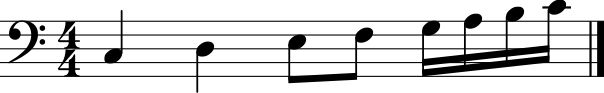

In [5]:
s = converter.parse('tinyNotation: 4/4 C4 D E8 F G16 A B c')
s.show()

Periods signify dots, "r" is for a rest, and "~" indicates a tie:

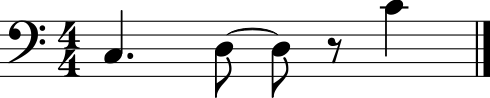

In [6]:
s = converter.parse('tinyNotation: 4/4 C.4 D8~ D8 r c4')
s.show()

Sharps, flats, and, if needed, naturals are indicated with `#`, `-` (not `b`) and, `n`, respectively:

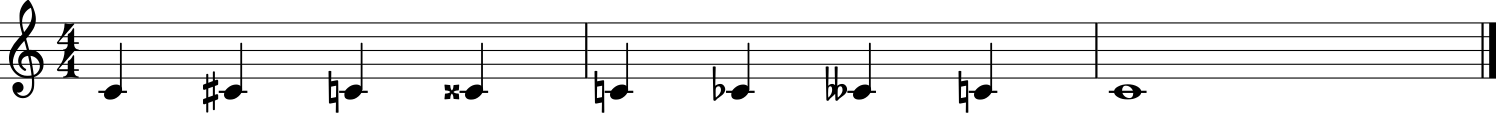

In [7]:
s = converter.parse('tinyNotation: 4/4 c4 c# c c## cn c- c-- c c1')
s.show()

A lyric syllable is specified by appending it after the note with an underscore:

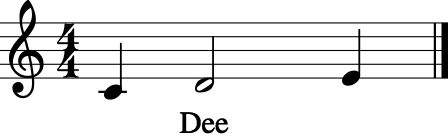

In [8]:
s = converter.parse('tinyNotation: 4/4 c4 d2_Dee e4')
s.show()

And, finally, triplets are possible by enclosing the triplet notes in curly brackets along with a special `trip` prefix:

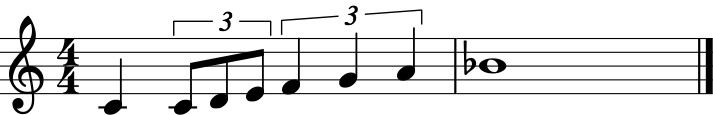

In [9]:
s = converter.parse('tinyNotation: 4/4 c4 trip{c8 d e} trip{f4 g a} b-1')
s.show()

Okay -- so what if you want to do something more complex?  Apply an id to a note with the "=" tag, and then make changes to it using music21:

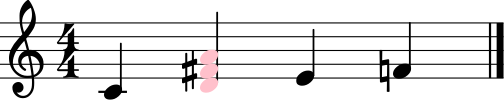

In [10]:
s = converter.parse('tinyNotation: 4/4 c4 d=id2 e f')
n = s.recurse().getElementById('id2')
ch = chord.Chord('D4 F#4 A4')
ch.color = 'pink'
n.activeSite.replace(n, ch)
s.show()

And that's how I use TinyNotation, about 90% of the time.  But when I need to, I can make something more complex...

## Expanding TinyNotation through new Tokens, Modifiers, and States

In order to keep TinyNotation tiny, there's a lot not included in it.  So many people have said to me over the years, "TinyNotation is almost perfect for what I need, but it just has to include one more thing..." If that "one more thing" were the same for everyone, it'd be no problem to add! But everyone has a different "one more thing" and if all the dozens of "one more things" were added, tinyNotation wouldn't be tiny anymore.

So instead, we've made it easy to expand TinyNotation through creating new Tokens (like the Notes, Rests, and TimeSignatures from above, separated by spaces), new Modifiers (such as the = for assigning .id, or the _ for assigning a lyric), and new States (such as the triplet state enclosed in curly brackets).

The first thing that we'll need to know in order to expand TinyNotation is how to get at the TinyNotation :class:`~music21.tinyNotation.Converter` itself (which is different from the basic `converter.parse()` call).  It's found in the `tinyNotation` module, and is called with a set of music to parse.

In [11]:
tnc = tinyNotation.Converter('6/8 e4. d8 c# d e2.')

We run the converter by calling `.parse()` on it and then there will be a `Stream` (generally a `stream.Part` object) in the `.stream` attribute of the `Converter`.

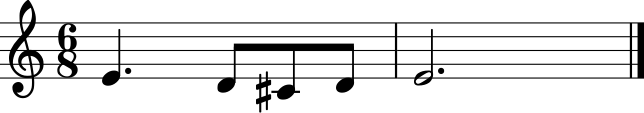

In [12]:
tnc.parse()
s = tnc.stream
s.show()

Now that we have a basic idea of how we can get a converter, we can start hacking it. 

TinyNotation does not have a way of specifying the Key (and thereby the KeySignature) of a piece or region.  Let's add that "one more thing" with a new :class:`~music21.tinyNotation.Token`:

In [13]:
class KeyToken(tinyNotation.Token):
    def parse(self, parent):
        keyName = self.token
        return key.Key(keyName)

The `KeyToken` is a subclass of the `tinyNotation.Token` class.  When it is parsed, `.parse()` is called and it is passed a reference to the `Converter` object, and important information is stored in the `self.token` attribute.  The Converter calling `parse()` expects that a :class:`~music21.base.Music21Object` or `None` will be returned.  Here we're going to return a :class:`~music21.key.Key` object.

Now that we've defined this particular Token, we'll need to teach the `Converter` when to call it.  We'll say that any token (that is, data separated by spaces) which begins with a `k` is a new `Key` object, and that the relevant data is everything after the `k`.  And we'll add this to a blank `Converter` object.

In [14]:
tnc = tinyNotation.Converter()
keyMapping = (r'k(.*)', KeyToken)
tnc.tokenMap.append(keyMapping)

Next, let's create a fragment of TinyNotation to see if this works, using the `load()` method:

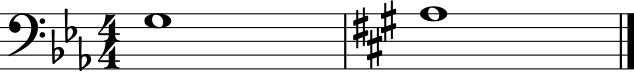

In [15]:
tnc.load('4/4 kE- G1 kf# A1')
tnc.parse()
s = tnc.stream
s.show()

Now that we have a way to create totally new Tokens, let's look at ways we can modify existing tokens.  Let's first create a simple :class:`~music21.tinyNotation.Modifier` that changes the color of individual notes after they've been parsed:

In [16]:
class ColorModifier(tinyNotation.Modifier):
    def postParse(self, m21Obj):
        m21Obj.color = self.modifierData
        return m21Obj

Now we'll modify our `Converter` object to make it so that the ColorModifier is run anytime that a color name is put in angle brackets after a Token, and then test it on a simple stream.

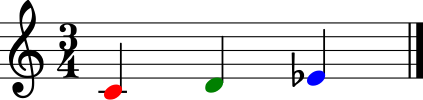

In [17]:
tnc.modifierAngle = ColorModifier
tnc.load('3/4 c4<red> d<green> e-<blue>')
tnc.parse()
tnc.stream.show()

There are six modifiers that can be used.  We've seen the `=data` (modifierEquals) and `_data` (modifierUnderscore) modifiers already, which don't take a closing tag, and we can add to them the `<data>` modifierAngle tag we just demonstrated, along with `*data*` (modifierStar), `[data]` (modifierSquare) and `(data)` (modifierParens) tags, which have a meaning ready for you to create.

Here's a less silly modifier which replaces the `Note` object that comes in with a :class:`~music21.harmony.ChordSymbol` object that combines the root name from the Note with the `data` from the modifier:

In [18]:
class HarmonyModifier(tinyNotation.Modifier):
    def postParse(self, n):
        cs = harmony.ChordSymbol(n.pitch.name + self.modifierData)
        cs.duration = n.duration
        return cs
    
tnc.modifierUnderscore = HarmonyModifier
tnc.load('4/4 C2_maj7 D4_m E-_sus4')
tnc.parse().stream.show('text')

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.harmony.ChordSymbol Cmaj7>
    {2.0} <music21.harmony.ChordSymbol Dm>
    {3.0} <music21.harmony.ChordSymbol E-sus4>
    {4.0} <music21.bar.Barline style=final>


If we leave in the bass note and instead add the ChordSymbol to the stream, then we'll be able to see it on the score:

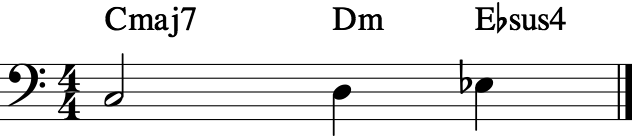

In [19]:
class HarmonyModifier(tinyNotation.Modifier):
    def postParse(self, n):
        cs = harmony.ChordSymbol(n.pitch.name + self.modifierData)
        self.parent().stream.append(cs)
        return n
    
tnc.modifierUnderscore = HarmonyModifier
tnc.load('4/4 C2_maj7 D4_m E-_sus4')
tnc.parse().stream.show()

Lastly are `State` conditions.  These affect more than one Token at a time and are (generally) enclosed in curly brackets (the "TieState" is a State that works differently but is too advanced to discuss here).  Let's create a silly State first, that removes stems from notes when it's closed:

In [20]:
class NoStemState(tinyNotation.State):
    def end(self):
        for n in self.affectedTokens:
            n.stemDirection = 'none'

Now we'll define `"nostem"` to be the start of a stemless state:

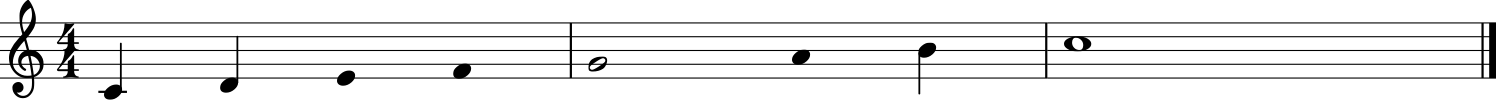

In [21]:
tnc.bracketStateMapping['nostem'] = NoStemState
tnc.load("4/4 c4 d nostem{e f g2 a4} b c'1")
tnc.parse().stream.show()

Okay, that's a good amount of fun and games, but here's what some people really want: using State to create chords.  To do this, we will prevent notes from being added to the stream as they are parsed, and then put a Chord into the stream at the end:

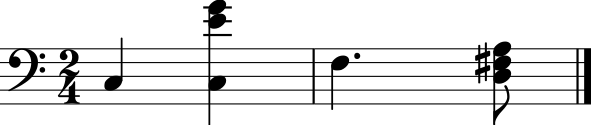

In [22]:
class ChordState(tinyNotation.State):
    def affectTokenAfterParse(self, n):
       super(ChordState, self).affectTokenAfterParse(n)
       return None # do not append Note object

    def end(self):
        ch = chord.Chord(self.affectedTokens)
        ch.duration = self.affectedTokens[0].duration
        return ch
    
tnc.bracketStateMapping['chord'] = ChordState
tnc.load("2/4 C4 chord{C4 e g} F.4 chord{D8 F# A}")
tnc.parse().stream.show()

That's a long enough chapter on a tiny enough concept.  We'll move on to how Streams and other objects are related to their prior incarnations though :ref:`Chapter 17, Derivations <usersGuide_17_derivations>`.